## Urban seismic monitoring in Brasilia, Brazil

This notebook is useful to reproduce all figures presented in the paper "Urban seismic monitoring in Brasilia, Brazil"

an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting

Required:

python obspy (and its dependencies) pandas jupyter notebook this should be easy to set up in a conda env: conda create -c conda-forge -n covid python=3.7 obspy pandas jupyter notebook

Authors: Susanne Maciel @sutaina, Marcelo Peres Rocha and Martin Schimmel

(using codes provided by https://github.com/ThomasLecocq/SeismoRMS)

In [2]:
import datetime
import os
from glob import glob

import matplotlib
from matplotlib.font_manager import FontProperties


matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd

import textwrap
from datetime import timedelta, date


wrapper = textwrap.TextWrapper(width=15,break_long_words=False)

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD

In [3]:
def recallPPSD(start,end,dataset):
    datelistA = pd.date_range(start.datetime, end.datetime, freq="D")
    
    ppsds = {}
    for day in datelistA:
        #print(day)
        datestr = day.strftime("%Y-%m-%d")
        fn_pattern = "{}_{}_*.npz".format(dataset, datestr)
        #print(fn_pattern)
        for fn in glob(fn_pattern):
            #print(fn)
            mseedid = fn.replace(".npz", "").split("_")[-1]
            if mseedid not in ppsds:
                ppsds[mseedid] = PPSD.load_npz(fn)#, allow_pickle=True)
            else:
                ppsds[mseedid].add_npz(fn)#, allow_pickle=True)
    
    GG1=[ppsd.get_mean() for mseedid, ppsd in ppsds.items()]
    return GG1,ppsds

In [4]:
def plotPPSD(G,start,end,event,specs,lw):
    K = np.where(G[0][1]==19.875)
    G[0][1][K]=None
    plt.semilogx(1/np.array(G[0][0]), np.array(G[0][1]),specs, Label = '%s--%s: %s'%(start.strftime("%y-%m-%d"),end.strftime("%y-%m-%d"),event), LineWidth=lw)
    

In [9]:
# Social events
dataset = "data/example"
# Common week in May 2017 monday-friday
snormal2017 = UTCDateTime("2017-04-25")
enormal2017 = UTCDateTime("2017-04-28")
Gnormal2017,ppsdnormal2017 = recallPPSD(snormal2017,enormal2017,dataset)

# COVID-19 2020 monday-friday
s0420 = UTCDateTime("2020-04-20")
e0420 = UTCDateTime("2020-04-24")
G0420,ppsd0420 = recallPPSD(s0420,e0420,dataset)

# Drivers strike (May 21, 2018 – Jun 1, 2018) monday-friday
sgreve2018 = UTCDateTime("2018-05-21")
egreve2018 = UTCDateTime("2018-05-25")
Ggreve2018,ppsdgreve2018 = recallPPSD(sgreve2018,egreve2018,dataset)

# Dilma Impeachment
sDilma2016 = UTCDateTime("2016-04-11")
eDilma2016 = UTCDateTime("2016-04-21")
GDilma2016,ppsdDilma2016 = recallPPSD(sDilma2016,eDilma2016,dataset)


# Dilma Impeachment
sDilma32016 = UTCDateTime("2016-03-10")
eDilma32016 = UTCDateTime("2016-03-20")
GDilma32016,ppsdDilma32016 = recallPPSD(sDilma32016,eDilma32016,dataset)

#World cup saturday-friday (7 days)
sworldcup = UTCDateTime("2014-06-16")
eworldcup = UTCDateTime("2014-06-26")
Gworldcup,ppsdworldcup = recallPPSD(sworldcup,eworldcup,dataset)

#World cup BrazilxCameroon
sworldcup23 = UTCDateTime("2014-06-23 16:00")
eworldcup23 = UTCDateTime("2014-06-23 19:00")
datasetHF = "data/HighFreqs/example"
Gworldcup23,ppsdworldcup23 = recallPPSD(sworldcup23,eworldcup23,datasetHF)

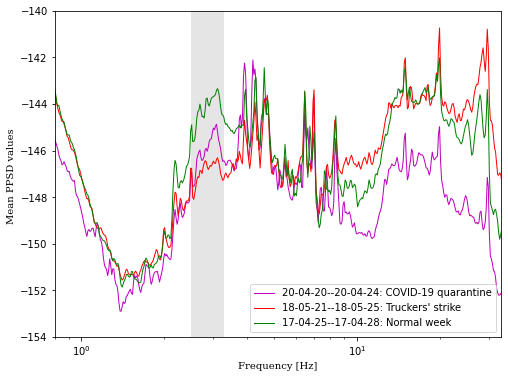

In [11]:
font = FontProperties()
font.set_family('serif')
font.fontsize=12

# Plot Greves
plt.figure(figsize=[8,6])
lw=1
plotPPSD(G0420,s0420,e0420, 'COVID-19 quarantine','-m',lw)
plotPPSD(Ggreve2018,sgreve2018,egreve2018,"Truckers' strike",'-r',lw)
plotPPSD(Gnormal2017,snormal2017,enormal2017, 'Normal week','-g',lw)
plt.legend(loc='lower right')
plt.xlim([0.8,33.3])
plt.ylim([-154,-140])
plt.xlabel("Frequency [Hz]",fontproperties=font)
plt.ylabel("Mean PPSD values ", fontproperties=font)
plt.axvspan(2.5,3.3,facecolor='k', edgecolor="none",alpha=0.1)


In [12]:
def rms(s, f):
    # Parseval: the RMS in time domain is the sqrt of the integral of the power spectrum
    return np.sqrt(np.trapz(s, f))


def displacementSus(ppsds,freqs):
    displacement_RMS = {}
    for mseedid, ppsd in ppsds.items():
        per = ppsd.period_bin_centers
        displacement_RMS[mseedid] = []
        for psd in ppsd.psd_values:
            RMS = {}
            for fmin, fmax in freqs:
                ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))

                # acceleration power spectrum in Hz
                spec = psd.copy()[ix][::-1]
                f = 1.0/per.copy()[ix][::-1]

                # remove NaNs from the list
                valid = np.where(np.isfinite(spec))[0]
                spec = spec[valid]
                f = f[valid]

                w2f = (2.0 * np.pi * f)

                # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
                amp = 10.0**(spec/10.) 

                # velocity spectrum (divide by omega**2)
                vamp = amp / w2f**2

                # displacement spectrum (divide by omega**2)
                damp =  vamp / w2f**2

                #RMS["%.2f-%.2f"%(fmin, fmax)] = rms(damp, f)
                RMS["%.2f-%.2f"%(fmin, fmax)] = rms(amp, f)

            displacement_RMS[mseedid].append(RMS)
            index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
        displacement_RMS[mseedid] = pd.DataFrame(displacement_RMS[mseedid], index=index)
        print(mseedid," rms done.")

        return displacement_RMS

def normaliza(df,base):
    dfN = (df[base]-df[base].mean())/(df[base].std())
    return dfN

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 576x576 with 0 Axes>

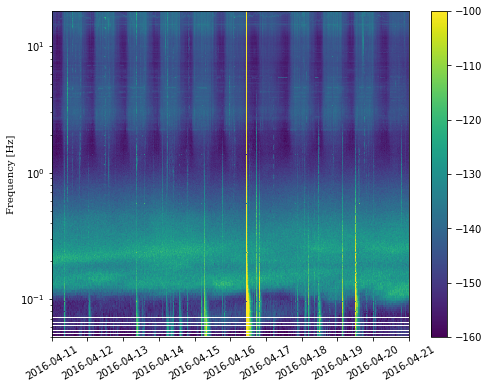

In [13]:
#Plot spectrograms (y-axis in Hz)

for mseedid, ppsd in ppsdDilma2016.items():
    P = ppsd.psd_values
    T = ppsd.step
PP=np.array(P)
TT=np.array(T)

L = PP.shape[0]

plt.figure(figsize=[8,8])

x = pd.date_range(start=sDilma2016.date,end=eDilma2016.date,periods=L)
y=1.0/GDilma2016[0][0]

font = FontProperties()
font.set_family('serif')
font.fontsize=12

plt.figure(figsize=[8,6])
plt.pcolor(x,y,PP.T)

plt.yscale('log')
plt.ylim([5e-2,19])
plt.ylabel("Frequency [Hz]", fontproperties=font)

plt.xticks(rotation=30)
plt.colorbar()
plt.clim([-160,-100])


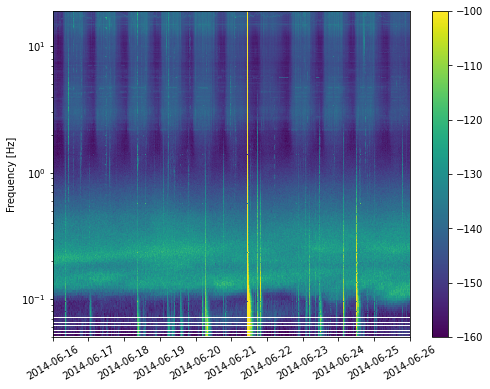

In [26]:
x = pd.date_range(start=sworldcup.date,end=eworldcup.date,periods=1034)
y=1.0/Gworldcup[0][0]




font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.fontsize=12
#font.set_style('italic')
plt.figure(figsize=[8,6])
plt.pcolor(x,y,PP.T)

plt.yscale('log')
plt.ylim([5e-2,19])
plt.ylabel("Frequency [Hz]", fontproperties=font)

plt.xticks(rotation=30)
plt.colorbar()
plt.clim([-160,-100])
